## Goal of the Project
To identify different group of customers based on the way they spend and also based on the way they have earlier interacted via Support services

### Expected outcomes
1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and
service these customers?

## Loading and understanding the data

In [256]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [257]:
#loading the data
data = pd.read_excel(io="Credit Card Customer Data.xlsx")

In [258]:
data.shape

(660, 7)

In [259]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


From the initial look of data, can see that the Sl_No and Customer Key columns are not required for model as they are just random arbitrary numbers

#### Hence can drop Sl_No & Customer Key from the data

In [260]:
data.drop(columns=['Sl_No', 'Customer Key'], inplace=True)

In [261]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


In [292]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0
group,660.0,0.722727,1.011511,0.0,0.0,0.0,1.0,3.0


Can see that there are no missing values. Also, the data type is integer for all the variables

In [262]:
# Visualizing histogram for all the columns to see the distribution

def plot_historgram(temp_data):
    plt.figure(figsize=(15,15))
    position = 1
    
    number_of_columns_in_data = len(temp_data.columns)
    n_columns_to_plot = 3
    n_rows_to_plot = np.ceil(number_of_columns_in_data / n_columns_to_plot)

    for column in temp_data.columns:
        plt.subplot(n_rows_to_plot,n_columns_to_plot, position)
        sns.distplot(a=temp_data[column], hist=False, label=column)
        position +=1

In [263]:
def plot_boxplot(temp_data):
    plt.figure(figsize=(15,15))
    position = 1
    
    number_of_columns_in_data = len(temp_data.columns)
    n_columns_to_plot = 3
    n_rows_to_plot = np.ceil(number_of_columns_in_data / n_columns_to_plot)

    for column in temp_data.columns:
        plt.subplot(n_rows_to_plot,n_columns_to_plot, position)
        sns.boxplot(temp_data[column])
        position +=1

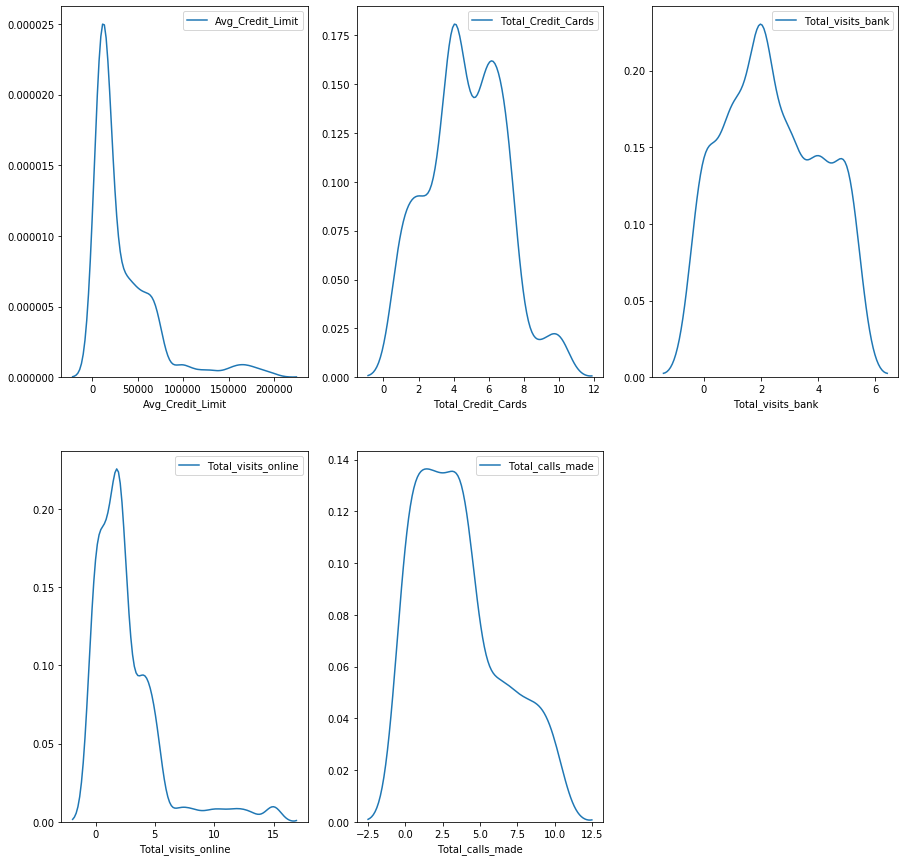

In [264]:
plot_historgram(data)

Average_credit_limit & Total_visits_online = Right skewed.

Lets try to validate statistically as well to confirm if the data is normally distributed or not

### Testing for normal distribution using stats.normaltest

In [265]:
#Testing statistically with normaltest

from scipy import stats

for column in data.columns:
    k2, p = stats.normaltest(data[column])
    alpha = 1e-3
    if p<alpha:
        is_normally_distributed = True
    else:
        is_normally_distributed = False
    print(f"{column} probability = {p}, is_normally_distributed = {is_normally_distributed}")

Avg_Credit_Limit probability = 4.758974990931043e-67, is_normally_distributed = True
Total_Credit_Cards probability = 0.020932996076690275, is_normally_distributed = False
Total_visits_bank probability = 2.4693570115970675e-53, is_normally_distributed = True
Total_visits_online probability = 3.7439992887051493e-69, is_normally_distributed = True
Total_calls_made probability = 1.6608354178603372e-12, is_normally_distributed = True


### Testing for normal distribution using stats.shapiro test

In [266]:
# Testing statistically with shapiro test

for column in data.columns:
    W, p = stats.shapiro(data[column])
    alpha = 0.05
    if p<alpha:
        is_normally_distributed = True
    else:
        is_normally_distributed = False
    print(f"{column} probability = {p}, is_normally_distributed = {is_normally_distributed}")


Avg_Credit_Limit probability = 1.2008759774935476e-31, is_normally_distributed = True
Total_Credit_Cards probability = 3.0227852013987866e-13, is_normally_distributed = True
Total_visits_bank probability = 9.017808266743116e-19, is_normally_distributed = True
Total_visits_online probability = 1.7103273533277765e-30, is_normally_distributed = True
Total_calls_made probability = 1.1514417199259852e-18, is_normally_distributed = True


#### Could not draw much conclusion using these tests. But, still with plain historgram, can see that avg_credit_limt and total_visits_online are not normally distributed. 

Proceeding with 
    Standardizing the values
    Box plot to confirm the outliers and treat them with IQR (Q1 and Q3 values)

In [267]:
from scipy.stats import zscore

data_z = data.apply(zscore)

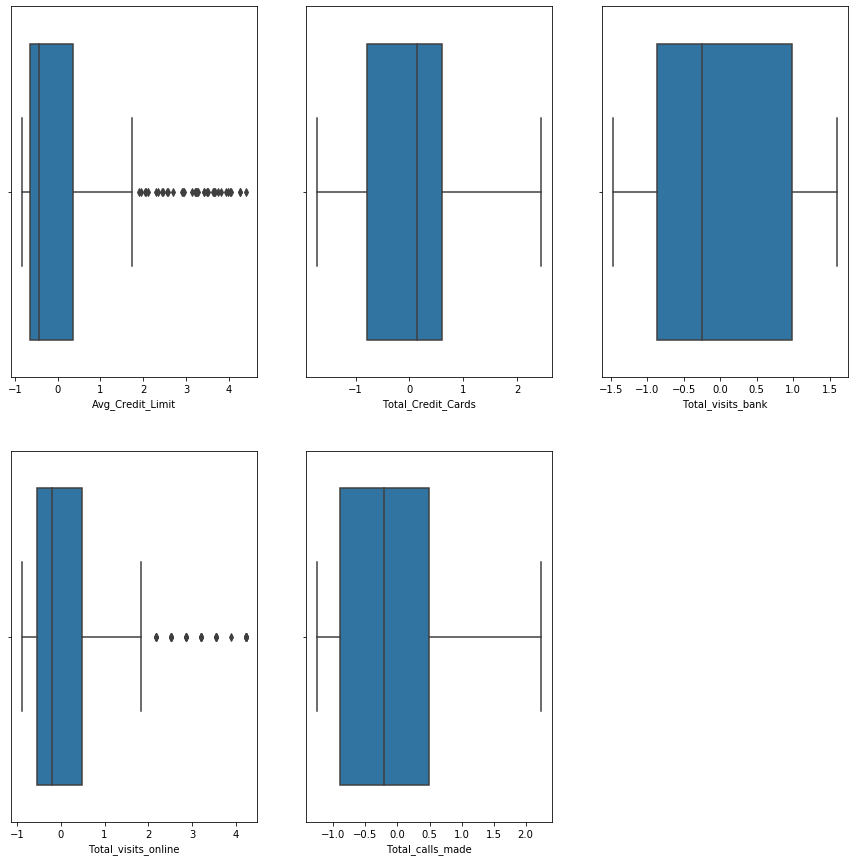

In [268]:
plot_boxplot(data_z)


Can see outliers only for avg_credit_limit and total_visits_online columns. Will check the % of values lying as outliers

In [269]:
temp_dict = []
for column in data_z.columns:
    q1, q2, q3 = data_z[column].quantile([0.25,0.5,0.75])
    IQR = q3 - q1
    gt_q3 = data_z[column].apply(lambda x: 1 if x > (q3 + 1.5*IQR) else 0)
    lt_q1 = data_z[column].apply(lambda x: 1 if x < (q1 - 1.5*IQR) else 0)
    temp = {}
    temp['column'] = column
    temp['Total values'] = data_z[column].shape[0]
    temp['Count of values > Q3'] = sum(gt_q3)
    temp['Count of values < Q1'] = sum(lt_q1)
    temp['Right skewed values %'] = round(sum(gt_q3)/data_z[column].shape[0] * 100, 2)
    temp['Left skewed values %'] = round(sum(lt_q1)/data_z[column].shape[0] * 100, 2)
    temp['UpperCapValue'] = q3 + 1.5*IQR
    temp['LowerCapValue'] = q1 - 1.5*IQR
    #print(temp)
    temp_dict.append(temp)

df_outlier_analysis = pd.DataFrame.from_dict(temp_dict).set_index('column')
df_outlier_analysis

,Total values,Count of values > Q3,Count of values < Q1,Right skewed values %,Left skewed values %,UpperCapValue,LowerCapValue
column,,,,,,,
Avg_Credit_Limit,660,39,0,5.91,0.0,1.873176,-2.169702
Total_Credit_Cards,660,0,0,0.00,0.0,2.674712,-2.864963
Total_visits_bank,660,0,0,0.00,0.0,3.739150,-3.620211
Total_visits_online,660,37,0,5.61,0.0,2.009184,-2.081494
Total_calls_made,660,0,0,0.00,0.0,2.590391,-2.997869


Only around 6% of data in avg_credit_limit and total_visits_online columns are right skewed.

Aligning those values to the upper cap values based on the IQR

In [270]:
outlier_columns = ['Avg_Credit_Limit', 'Total_visits_online']
for column in outlier_columns:
    q1, q2, q3 = data_z[column].quantile([0.25,0.5,0.75])
    IQR = q3 - q1
    upper_bound = (q3 + 1.5*IQR)
    data_z[column]=data_z[column].apply(lambda x: upper_bound if x>(upper_bound) else x)

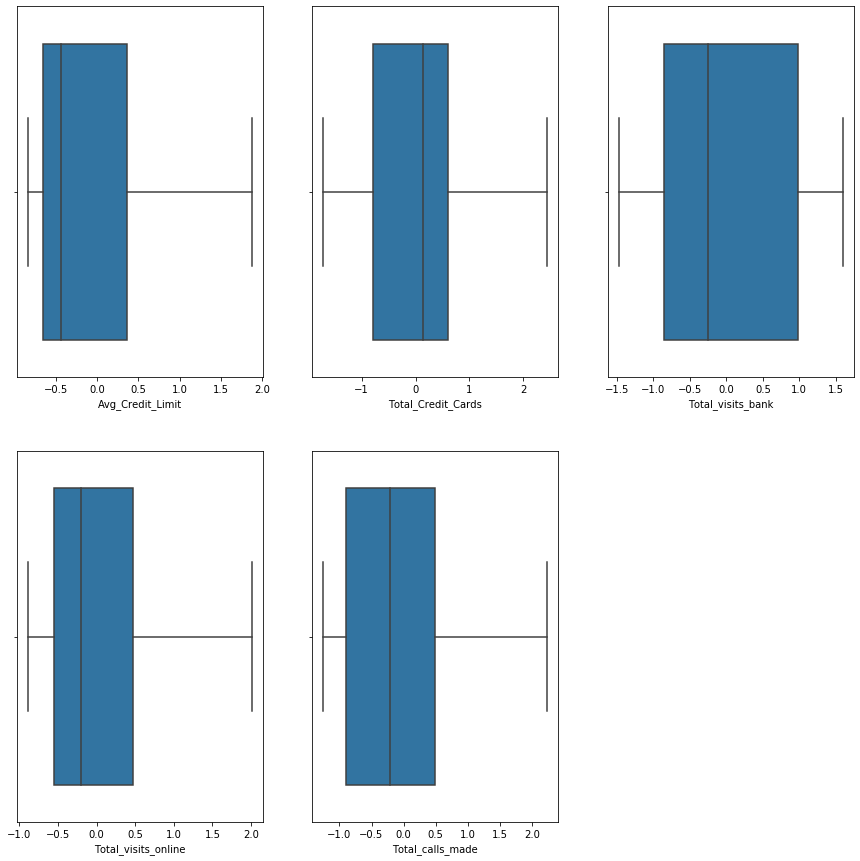

In [271]:
plot_boxplot(data_z)


Can see that the outliers are treated. 
Should check for normal distribution again now with this latest data - scaled & outlier treated

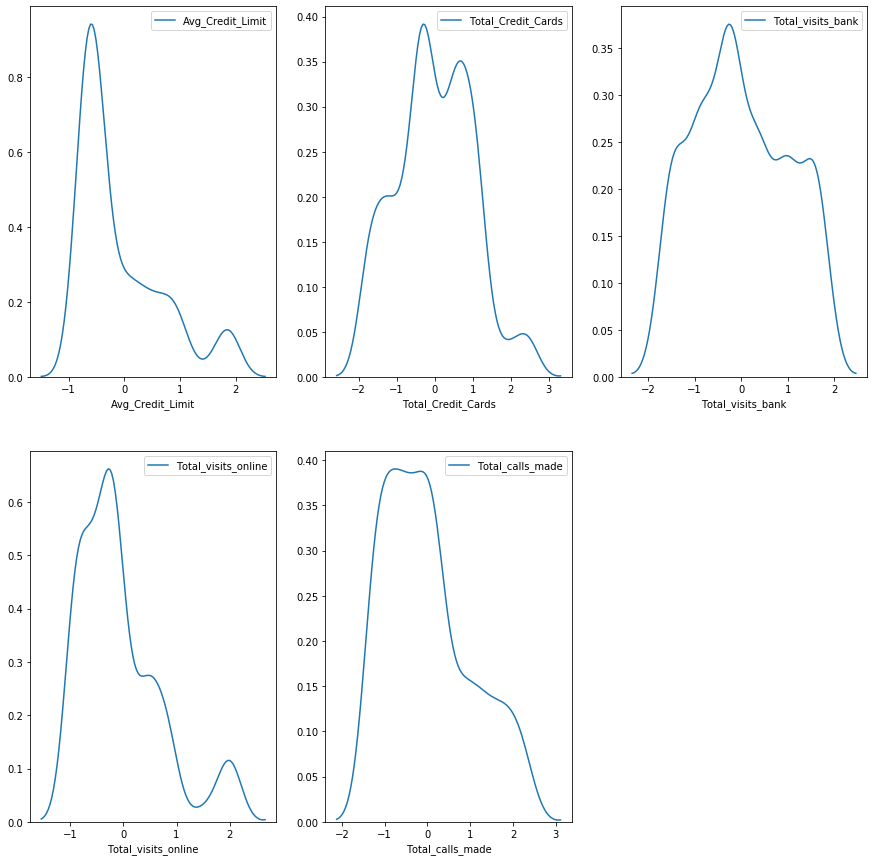

In [272]:
plot_historgram(data_z)

### Observations
Can see that there are kind of group of customers, at least based on the Total_visits_online distribution

Can see that the distribution is still not completely normal

Can try applying log transformation to all the columns to see if that helps in anyway to get data to align to normal distribution

In [273]:
data_z_t = pd.DataFrame()

for column in data_z.columns:
    data_z_t[column] = np.cbrt(data_z[column])

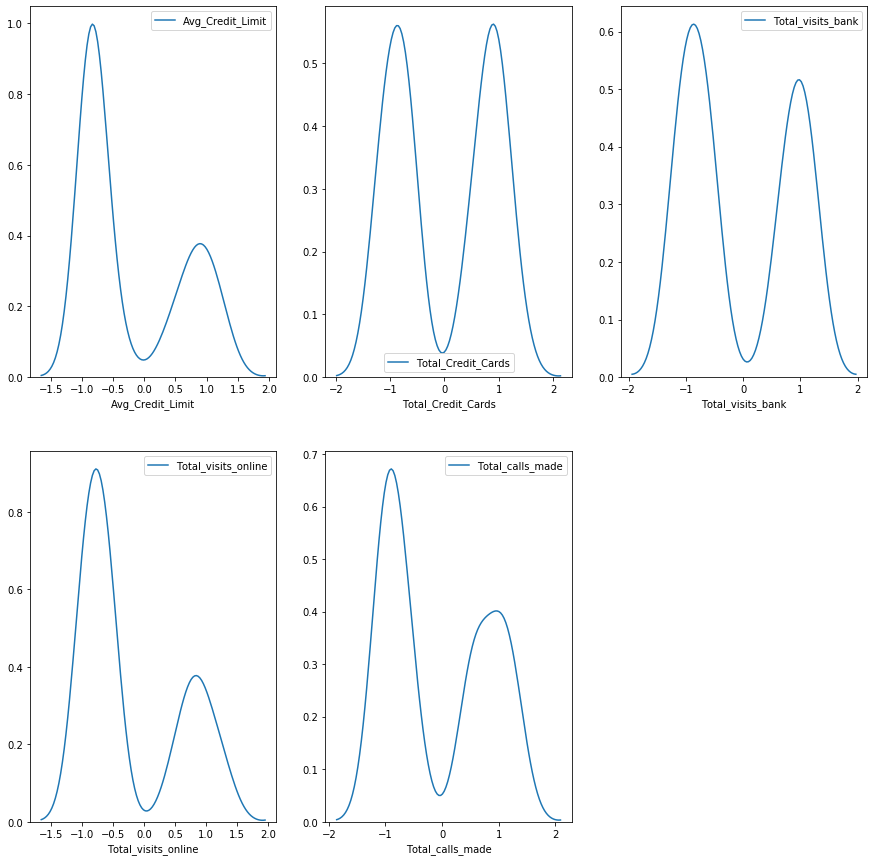

In [274]:
plot_historgram(data_z_t)

With cube root transformation to all the columns, can see that there are minimum of 2 cluster of customers.

However, not using transformed data, as the original standardized data seems to be more normally distributed.

## Bivariate analysis

### Pair plot to understand if there are any tight correlation between these variables

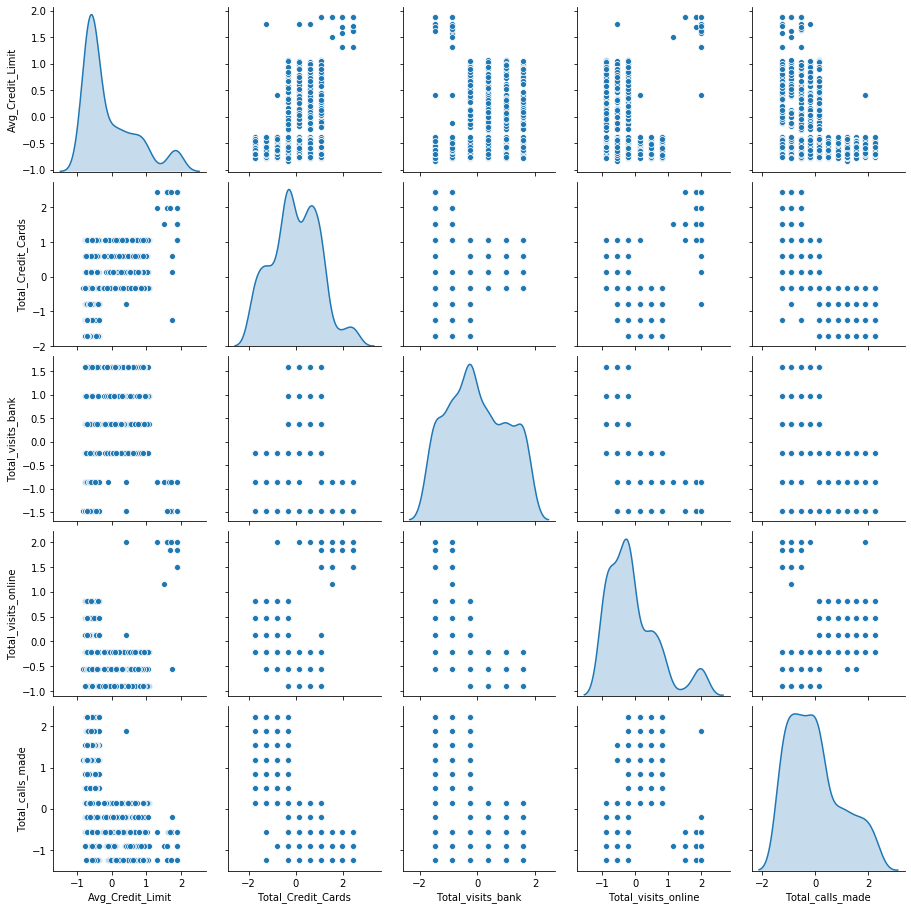

In [275]:
sns.pairplot(data_z, diag_kind='kde')

Do not see any clear linear relationship though. Will check with the pearsons correlation value to confirm, if there are any linearly correlated variables

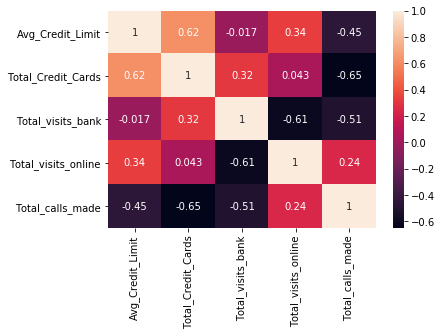

In [276]:
corr = data_z.corr()

sns.heatmap(data=corr, annot=True)

#### Identifying the variables that has the correlation more than (+/-) 0.55

In [277]:
for column in corr.columns:
    for correlated_column in corr[column].keys():
        correlation_value = corr[column][correlated_column]
        if np.abs(correlation_value) > 0.55 and column != correlated_column:
            print(f"{column} / {correlated_column} - {correlation_value}")

Avg_Credit_Limit / Total_Credit_Cards - 0.6164703809459678
Total_Credit_Cards / Avg_Credit_Limit - 0.6164703809459678
Total_Credit_Cards / Total_calls_made - -0.651251497605409
Total_visits_bank / Total_visits_online - -0.6123875313584913
Total_visits_online / Total_visits_bank - -0.6123875313584913
Total_calls_made / Total_Credit_Cards - -0.651251497605409


#### Highly correlated combinations 

Avg_Credit_Limit / Total_Credit_Cards

Total_Credit_Cards / Total_calls_made

Total_calls_made / Total_Credit_Cards


Can create corresponding new variables with ratio between them

In [278]:
data_z['creditLimit_creditCards'] = data_z['Avg_Credit_Limit'] / data_z['Total_Credit_Cards']
data_z['creditCards_callsMade'] = data_z['Total_Credit_Cards'] / data_z['Total_calls_made']
data_z['callsMade_CreditCards'] = data_z['Total_calls_made'] / data_z['Total_Credit_Cards']

Rather multiply Avg credit limit & Total credit cards

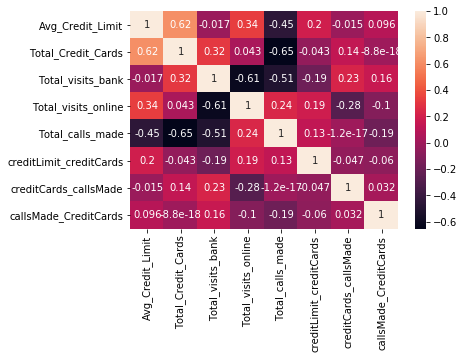

In [279]:
corr = data_z.corr()
sns.heatmap(data=corr, annot=True)

In [280]:
#data_z.drop(columns=['Total_Credit_Cards'], inplace=True)

Can remove the Total_Credit_Cards column from the input, as that variable is correlated with multiple variables. And removing them, can make sure there is no multi-colinearity.

But not removing them, as at the end, when we would like to categorize the clusters, we may not be able to make business meaning out of it.

## Clustering analysis

### K-Means Clustering

In [293]:
#importing KMeans library
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [294]:
wcss = []
silhoutte_score = []

for num_clusters in range(2,10):
    KMeansModel = KMeans(n_clusters=num_clusters, init='k-means++', random_state = 5)
    KMeansPredictions = KMeansModel.fit_predict(data_z)
    wcss.append(KMeansModel.inertia_)
    silhoutte_score.append(silhouette_score(data_z, KMeansPredictions))
    
    

In [283]:
perc_explained = []
perc_explained_diff = []
idx=0
max_wcss = 0

for value in wcss:
    if idx == 0:
        max_wcss = value
    
    percent = round((value*100)/max_wcss,2)
    perc_explained.append(percent)
    if idx==0:
        perc_explained_diff.append(0)
    else:
        perc_explained_diff.append(previousPercent - percent)
    previousPercent = percent
    idx +=1

 

In [284]:
kmeans_stats = pd.DataFrame()
kmeans_stats['n_clusters'] = list(range(2,10))
kmeans_stats['WCSS'] = wcss
kmeans_stats['WCSS - Variations explained'] = perc_explained
kmeans_stats['% difference of WCSS compared to previous iter'] = perc_explained_diff
kmeans_stats['Silhoutte Score'] = silhoutte_score
kmeans_stats

,n_clusters,WCSS,WCSS - Variations explained,% difference of WCSS compared to previous iter,Silhoutte Score
0,2,9951.074365,100.00,0.00,0.311042
1,3,8213.930373,82.54,17.46,0.330119
2,4,6888.901068,69.23,13.31,0.315758
3,5,5880.142969,59.09,10.14,0.301693
4,6,4890.211811,49.14,9.95,0.337711
5,7,4136.113660,41.56,7.58,0.361260
6,8,3479.003012,34.96,6.60,0.403764
7,9,3027.483621,30.42,4.54,0.421109


### Can see that the WCSS variation drops to less than 10% after cluster count of 4. 

### Also, there is no much significant difference in the silhoutte score as well. 

### Hence considering 4 clusters as the optimal number

Text(0.5, 1.0, 'Finding best number of clusters based on WCSS')

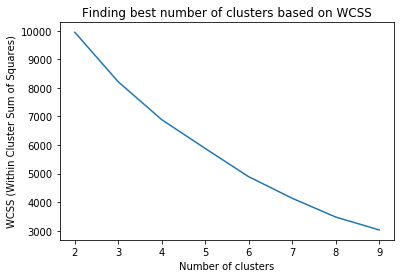

In [285]:
plt.plot(range(2,10), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Finding best number of clusters based on WCSS')

In [286]:
KMeansModel = KMeans(n_clusters=4, init='k-means++', random_state = 5)

In [287]:
clusterValues = KMeansModel.fit_predict(data_z)

In [288]:
data['group'] = clusterValues

In [289]:
data['group'].value_counts()

0    383
1    148
3     71
2     58
Name: group, dtype: int64

In [290]:
data_groupby_max = data.groupby(['group']).max()
data_groupby_min = data.groupby(['group']).min()

In [291]:
data_groupby_max.values()

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
data_groupby_max

In [ ]:
data_groupby_min

In [ ]:
data.groupby(['group']).quantile(q=[0.95])

Above table shows the 95th percentile of values for each variable within a cluster

0 - High credit limit, high visits online, high calls made

1 - average credit limit, ,less visits online, less calls made

2 - High credit limit, high visits online, less calls made, also more # of credit cards

3 - less credit limit, average visits online, high calls made

In [ ]:
finalKmeansSilhoutte = silhouette_score(data_z, clusterValues)
finalKmeansWCSS = KMeansModel.inertia_
print(f"Final KMeans Model - WCSS = {finalKmeansWCSS}, Silhoutte score - {finalKmeansSilhoutte}")

## Hierarchical Clustering

In [ ]:
# importing libraries from scipy
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist

In [ ]:
# To calculate the cophenetic coefficient for the dendrograms created with different linkages
linkage_methods=['single','complete','average','ward','median']

results_linkage_cophecoeff = []

for linkage_method in linkage_methods:
    
    plt.figure(figsize=(20, 5))
    plt.xlabel('sample index')
    plt.ylabel('Distance')
    
    Z = linkage(data_z, linkage_method)
    cophen_corr,cophn_dist=cophenet(Z,pdist(data_z))
    dendrogram(Z,leaf_rotation=90.0,p=5,leaf_font_size=10,truncate_mode='level')
    
    plt.title(f"Dendrogram - With Linkage method = {linkage_method}, cophenetic coeff = {cophen_corr}")
    
    plt.tight_layout()
    plt.show()
    
    results_linkage_cophecoeff.append((linkage_method, cophen_corr))


In [ ]:
pd.DataFrame(results_linkage_cophecoeff, columns=['Linkage Method', 'Cophenetic Coefficient'])

Can see that dendrogram with Average Linkage has high cophenetic coefficient

### Agglomerative Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering 

In [ ]:
affinity_list = ['euclidean', 'minkowski', 'mahalanobis', 'jaccard', 'cityblock']

dist_list = []
cluster_count_list = []
sil_score_list = []

for num_clusters in range(3,6):
    for affinity_choice in affinity_list:
        df_labels = pd.DataFrame()
        hc_model = AgglomerativeClustering(n_clusters=num_clusters, affinity=affinity_choice,  linkage='average')
        hc_model.fit(data_z)
        df_labels['hc_cluster_labels'] = hc_model.labels_
        sil_score = silhouette_score(data_z, df_labels['hc_cluster_labels'])
        dist_list.append(affinity_choice)
        cluster_count_list.append(num_clusters)
        sil_score_list.append(sil_score)

hc_analysis = pd.DataFrame()
hc_analysis['Affinity method'] = dist_list
hc_analysis['Cluster Count'] = cluster_count_list
hc_analysis['Silhoutte Score'] = sil_score_list

In [ ]:
hc_analysis.groupby(by=['Affinity method','Cluster Count']).mean()

In [ ]:
hc_analysis[hc_analysis['Cluster Count'] == 4]

#### Can see that with cityblock (manhattan) distance, silhoutte score is maximum

## Visualize the HC (Agglomerative Clustering) with Distance=CityBlock, Linkage=Average

In [ ]:
hc_final_model = AgglomerativeClustering(n_clusters=4, affinity='cityblock',  linkage='average')
hc_final_model.fit(data_z)

In [ ]:
data['group'] = hc_final_model.labels_

In [ ]:
data.head()

In [ ]:
data['group'].value_counts()

Can see that the group is not well distributed, when compared against the way KMeans clustered the customers

In [ ]:
data.groupby(['group']).quantile(q=[0.95])

0 - High Credit Limit, More Credit Cards, More visits online, More Calls Made (High Profile - Interact more)

1 - Less Credit Limit, Less Credit Cards, Average Visits online / Calls made (Low Profile - Average Interaction)

2 - Average Credit Limit, Average number of Credit Cards, Less visits online / Calls made (Medium Profile - Less Interaction)

3 - High Credit Limit, Average number of Credit Cards, High Visits online, Less Calls Made (High Profile - Prefer visiting online than over call)

## Summary

Though the Silhoutte score is high with the Hierarchial clustering, the distribution is not that normal as compared to KMeans clustering

Hence, would recommend KMeans clustering model

Can see 4 different type of customers, as listed below

0 - High credit limit, high visits online, high calls made

1 - average credit limit, ,less visits online, less calls made

2 - High credit limit, high visits online, less calls made, also more # of credit cards

3 - less credit limit, average visits online, high calls made